# Lectura de la Información
En este notebook nos enfocaremos en extraer la data de los archivos comprimidos y unificar las fuentes de datos. Muchas de los métodos/funciones utilizadas, serán cargadas de un archivo utils.py previamente generado para evitar sobrecarga de código en este notebook.

### Cargar librerías necesarias

In [51]:
from utils import *
import shutil
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

### Listar archivos comprimidos y extraer archivos

In [2]:
files=[i for i in os.listdir("../") if i.endswith(".zip")] ## ../ hace referencia a un nivel atrás al actual, en donde se encuentran los archivos .zip
_=[shutil.unpack_archive(f'../{i}', f'../data/') for i in files]

In [4]:
##extraer paths de cada archivo csv
filepaths=get_csv_filepaths([i.replace(".zip","") for i in files])

### Para leer las fuentes de datos se definirán grupos de archivos denotados por la variable filegroups

In [5]:
##NOTA: NO EJECUTAR SI PREVIAMENTE SE HAN GENERADO LOS ARCHIVOS .pickle por filegroup
filegroups=['personajuridica','personanatural','produccion','recaudo','siniestro']     
data={}
for filegp in filegroups:
    data[filegp]=read_by_filegroup(filegp,filepaths,save_output=True)

In [4]:
##leer archivos pickle (Checkpoint), ejecutar solo si se ejecutó la celda anterior en algún momento
filegroups=['personajuridica','personanatural','produccion','recaudo','siniestro']
data={}
for filegp in filegroups:
    data[filegp]=pd.read_pickle(f"{filegp}.pickle",compression="gzip")

### Lectura información tipo de Polizas

In [6]:
FILENAME_POLIZAS="../CODIGOS PRODUCTOS SISE.xls"
tipo_poliza,tipo_subramo,tipo_prod=pd.read_excel(FILENAME_POLIZAS,sheet_name="tipo poliza",dtype={'cod_ramo': int, 'cod_tipo_poliza': int,'txt_desc':str}),\
                                    pd.read_excel(FILENAME_POLIZAS,sheet_name="productos rc subramo",dtype={'cod_ramo': int, 'cod_subramo': int,'txt_desc':str}),\
                                    pd.read_excel(FILENAME_POLIZAS,sheet_name="productos 3g",dtype={'ramo': int, 'codigo': str})
tipo_poliza.head()

,cod_ramo,cod_tipo_poliza,txt_desc
0,1,1,SECTOR OFICIAL
1,1,2,SECTOR PRIVADO
2,1,3,GLOBAL SECTOR OFICIAL
3,1,4,GLOBAL SECTOR PRIVADO
4,1,5,POLICIA NACIONAL


## Esquema de generación de la variable objetivo: churn

- Se deben explorar los campos que permiten unir las diversas fuentes de información, para ello deberá explorarse el código de asegurado o el número de la póliza
- Debido a que solo se tiene un año de historia, debemos tomar un periodo base y observar 12 meses después el comportamiento de los asegurados, para encontrar si renovaron o no (churn) su poliza. A través de este análisis generaremos la variable objetivo. Esto puede observarse en el siguiente gráfico. 

![img](images/caso_uso_previsora.jpg)


- Sólo serán tenidas en cuenta las pólizas de 12 meses de duración




In [142]:
##detectar columnas tipo fecha y convertirlas a tipo datetime

date_cols=[i for i in data['produccion'].columns.values if "fecha" in i.lower()]

## crear una copia del dataframe para generar reproducibilidad
data_prod=data['produccion'].drop_duplicates().copy()

def col_to_dateutc(column,trim=False):
    if trim:
        return pd.to_datetime(column,errors="coerce").dt.strftime('%m-%Y')
    else:
        return pd.to_datetime(column,errors="coerce")

for col in date_cols:
    data_prod.loc[:,col]=col_to_dateutc(data_prod[col])
    data_prod.loc[:,col+"trim"]=col_to_dateutc(data_prod[col],trim=True)


print("Total filas antes de remover duplicados: ",data['produccion'].shape[0])
print("Total filas después de remover duplicados: ",data_prod.shape[0])

Total filas antes de remover duplicados:  1054290
Total filas después de remover duplicados:  1003437


In [143]:
##obtener descripción tipo de poliza y de producto
#tipo_poliza,tipo_subramo,tipo_prod
data_prod=data_prod.merge(tipo_poliza.rename(columns={'txt_desc':'tipo_poliza_name'}),how="left",left_on=['RamoTecnico__c','Tipo_poliza_c'],right_on=['cod_ramo','cod_tipo_poliza'])

In [144]:
##Añadir descripción tipo producto

def try_convert(num):
    try: 
        val=str(int(num))
        return val
    except:
        return "99999"
        
data_prod.loc[:,'Producto__c']=data_prod.Producto__c.apply(lambda d: try_convert(d)) ## se debe realizar un paso previo ya que el Producto__c está con valores decimales

data_prod=data_prod.merge(tipo_prod.rename(columns={'descripcion reducida':'tipo_prod_desc'}).drop(columns="producto"),how="left",left_on=['RamoTecnico__c','Producto__c'],right_on=['ramo','codigo'])


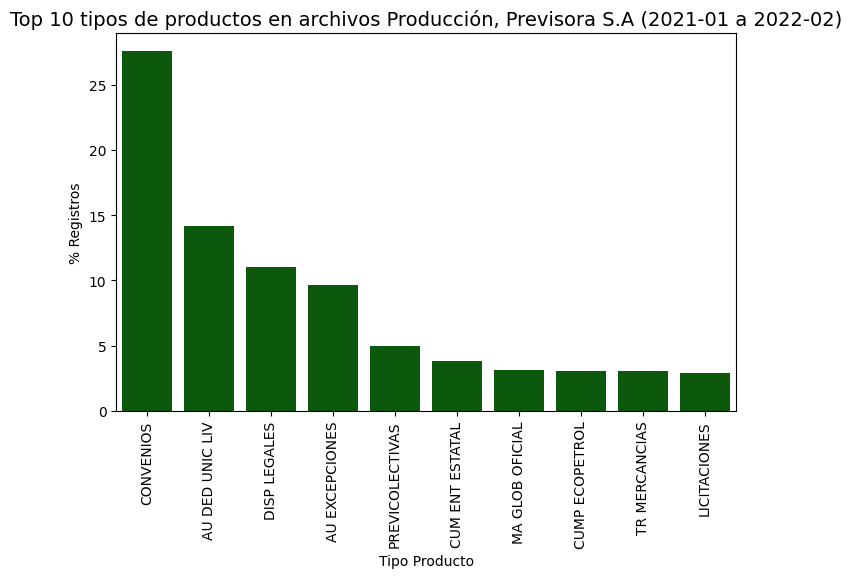

In [145]:
data_tipo_prod=data_prod.tipo_prod_desc.value_counts(normalize=True).head(10).reset_index()

f,ax=plt.subplots(figsize=(8,5),dpi=100)
sns.barplot(x=data_tipo_prod['index'],y=data_tipo_prod['tipo_prod_desc']*100,data=data_tipo_prod,ax=ax,color="darkgreen");
ax.set_title("Top 10 tipos de productos en archivos Producción, Previsora S.A (2021-01 a 2022-02)",size=14)
ax.set_xlabel("Tipo Producto")
ax.set_ylabel("% Registros")
plt.xticks(rotation=90);

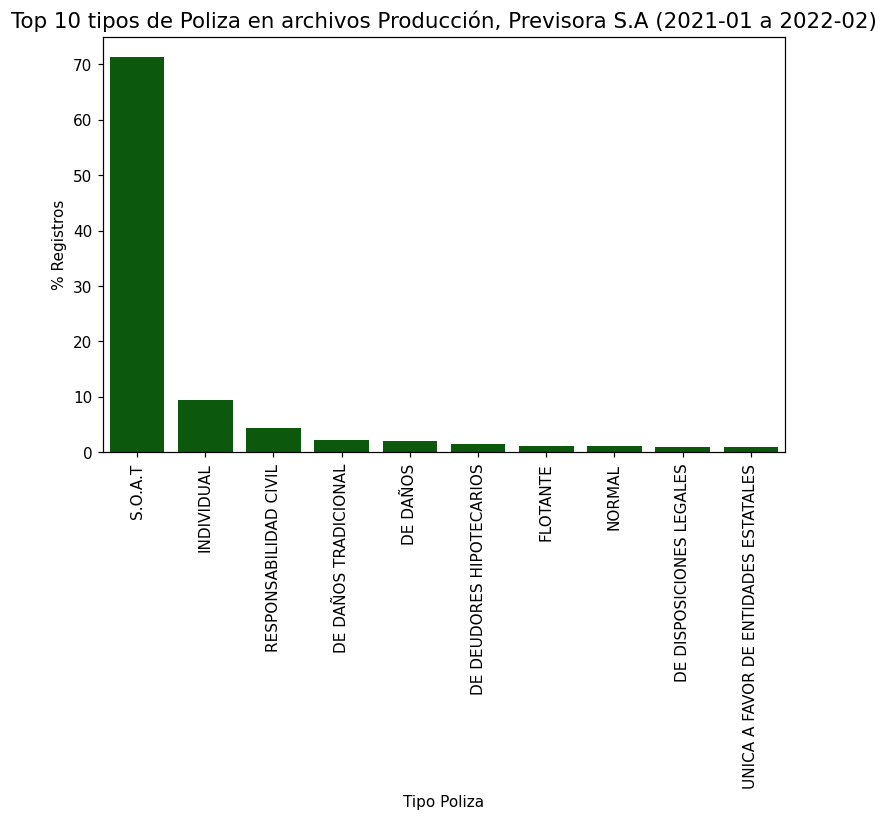

In [147]:
data_tipo_poliza=data_prod.tipo_poliza_name.value_counts(normalize=True).head(10).reset_index()

f,ax=plt.subplots(figsize=(8,5),dpi=110)
sns.barplot(x=data_tipo_poliza['index'],y=data_tipo_poliza['tipo_poliza_name']*100,data=data_tipo_poliza,ax=ax,color="darkgreen");
ax.set_title("Top 10 tipos de Poliza en archivos Producción, Previsora S.A (2021-01 a 2022-02)",size=14)
ax.set_xlabel("Tipo Poliza")
ax.set_ylabel("% Registros")
plt.xticks(rotation=90);

In [148]:
## eliminar columnas innecesarias generadas en los merge
data_prod.drop(columns=['cod_ramo','cod_tipo_poliza','ramo','codigo'],inplace=True)

In [149]:
#calcular vigencia en días de la poliza, para el MVP asumiremos solo polizas de 365 días.
data_prod.loc[:,'vigencia_dias']=data_prod.apply(lambda d: (d['FechaFinVigencia__c']-d['FechaInicioVigencia__c']).days,axis=1)
data_prod_365=data_prod.query("""vigencia_dias==365""").copy()

### Cálculo de variable objetivo: churn

Para este MVP usaremos las polizas cuya vigencia empieza en enero o febrero de 2021 y observaremos si en el mes de su vencimiento, se observan o no nuevas polizas para el mismo código de asegurado (Asegurado__c) tipo ramo y tipo poliza (RamoTecnico__c,Tipo_poliza_c).

In [150]:
fecha_inicio=["01-2021","02-2021"] ##fecha para iniciar el monitoreo de polizas un año después
fecha_fin=["01-2022","02-2022"]  ##fecha para finalizar el monitoreo de las pólizas
emisiones_inicio=data_prod_365.query('FechaInicioVigencia__ctrim=="{}" or FechaInicioVigencia__ctrim=="{}" '.format(fecha_inicio[0],fecha_inicio[1]))
emisiones_final=data_prod_365.query('FechaInicioVigencia__ctrim=="{}" or FechaInicioVigencia__ctrim=="{}"'.format(fecha_fin[0],fecha_fin[1]))
print(f"Total emisiones en {fecha_inicio} : {len(set(emisiones_inicio.NumeroPoliza__c.values))} polizas")
print(f"Total emisiones al finalizar el monitoreo en {fecha_fin} : {len(set(emisiones_final.NumeroPoliza__c.values))} polizas")

Total emisiones en ['01-2021', '02-2021'] : 60441 polizas
Total emisiones al finalizar el monitoreo en ['01-2022', '02-2022'] : 85847 polizas


In [190]:
churn_data=emisiones_inicio[['Asegurado__c','CodigoTipoAsegurado__c','PuntoVenta__c','Producto__c','tipo_poliza_name','tipo_prod_desc','ClaseVehiculo__c','MarcaVehiculo__c','MdeloVehiculo__c','TipoVehiculo__c','NumeroPoliza__c','FechaInicioVigencia__ctrim','vigencia_dias','RamoTecnico__c','Tipo_poliza_c']].drop_duplicates().\
        merge(emisiones_final[['Asegurado__c','CodigoTipoAsegurado__c','Producto__c','FechaInicioVigencia__ctrim','vigencia_dias','RamoTecnico__c','Tipo_poliza_c']].drop_duplicates().\
        rename(columns={'vigencia_dias':'end_vig','FechaInicioVigencia__ctrim':'FechaInicio_ctrl'}),how="left",on=['Asegurado__c','CodigoTipoAsegurado__c','Producto__c','RamoTecnico__c','Tipo_poliza_c'])
churn_data.loc[:,'churn']=churn_data.end_vig.isnull()
print("Total Registros: ",churn_data.shape[0])

Total Registros:  67885


<AxesSubplot:title={'center':'Comportamiento de Churn en 2021-01 y 2021-02'}>

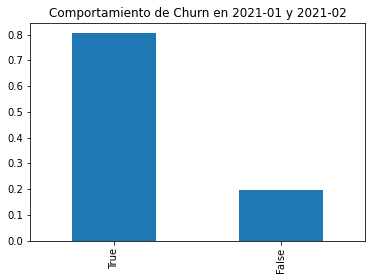

In [35]:
churn_data.churn.value_counts(normalize=True).plot(kind="bar",title="Comportamiento de Churn en 2021-01 y 2021-02")

## Extraer Variables de Dimensiones Adicionales
### Datos de persona natural

In [48]:
#obtener nombre de ciudad usando datos del Dane
ciudades=pd.read_excel("public_data\Codigos Dane municipios.xlsx",header=1,dtype={'CÓDIGO':int})
persona_natural=data['personanatural'].merge(ciudades[['MUNICIPIO','CÓDIGO']].rename(columns={'CÓDIGO':'Ciudad__c','MUNICIPIO':'ciudad_name'}),how="left",on="Ciudad__c").copy()

In [49]:
#seleccionar variables y remover duplicadas
persona_natural=persona_natural[['CodigoAsegurado__c','Activos__c','AnnualRevenue','MontoAnual__c','OtrosIngresos__c','Profesion__pc','EgresosAnuales__c','EstadoCivil__pc','PersonBirthDate','Genero__pc','NumeroIdentificacion__c']].drop_duplicates()

In [52]:
#calcular edad
from datetime import datetime
persona_natural.loc[:,'PersonBirthDate']=pd.to_datetime(persona_natural.PersonBirthDate,errors="coerce")
persona_natural.loc[:,'edad']=persona_natural.PersonBirthDate.apply(lambda d: (pd.to_datetime(datetime.now())-d).days/365.0 if not pd.isnull(d) else np.nan)

### Datos de Recaudo


In [183]:
# Recaudo data
recaudo=data['recaudo'][['CodigoAsegurado__c','RamoTecnico__c','NumeroPoliza__c','Tipo_poliza_c','Producto__c','FechaProduccion__c','CodigoPlanPagos__c','EstadoPagos']].drop_duplicates()
recaudo.loc[:,'Producto__c']=recaudo.Producto__c.apply(lambda d: try_convert(d))

### Datos de Siniestro

Para algunos calculos necesitaremos los valores en SMMLV del año de referencia, por tanto obtenemos el histórico de salarios de BANREP


In [100]:
salarios_min=pd.read_excel("public_data\salarios_minimos_brep.xlsx",skiprows=5,skipfooter=12,dtype={'Año (aaaa)':int}).\
    rename(columns={"Salario mínimo mensual (COP)":'sal_mens_min','Año (aaaa)':'anio'})
salarios_min=salarios_min[['anio','sal_mens_min']].set_index('anio').to_dict(orient="index")

In [127]:
##convertir columnas tipo fecha a timestamp

date_cols=[i for i in data['siniestro'].columns.values if "fecha" in i.lower()]

## crear una copia del dataframe para generar reproducibilidad
data_siniestro=data['siniestro'].drop_duplicates().copy()


for col in date_cols:
    data_siniestro.loc[:,col]=col_to_dateutc(data_siniestro[col])
    data_siniestro.loc[:,col+"trim"]=col_to_dateutc(data_siniestro[col],trim=True)

In [155]:
#calcular valor pagado por siniestro en SMMLV para poder comparar sumarlos o compararlos en el tiempo
data_siniestro_prev=data_siniestro.query("FechaOcurrenciaSiniestro__c<20210131")
data_siniestro_prev.loc[:,'ValorPagadoSiniestros__smmlv']=data_siniestro_prev.apply(lambda d: d['ValorPagadoSiniestros__c']/salarios_min[d['FechaOcurrenciaSiniestro__c'].year]['sal_mens_min'] if d['FechaOcurrenciaSiniestro__c'].year in salarios_min.keys() else salarios_min[2020],axis=1)

In [156]:
#calcular años hasta el el 31 de enero de 2021 (fecha desde que inicia el análisis churn)
data_siniestro_prev.loc[:,'tiempo_stro_hasta012021']=data_siniestro_prev.FechaOcurrenciaSiniestro__c.apply(lambda d: (pd.to_datetime("31-01-2021")-d).days/365)

In [157]:
#generar variables por CodigoAsegurado__c
data_siniestro_prev_agg=data_siniestro_prev.groupby(['CodigoAsegurado__c']).agg({'IdentificacionSiniestro__c':lambda x: x.nunique(),\
                        'ValorPagadoSiniestros__smmlv':np.sum,'tiempo_stro_hasta012021':np.min}).reset_index().\
                        rename(columns={'IdentificacionSiniestro__c':'total_siniestros','ValorPagadoSiniestros__smmlv':'total_pagado_smmlv','tiempo_stro_hasta012021':'anios_ultimo_siniestro'})
data_siniestro_prev_agg.head()

,CodigoAsegurado__c,total_siniestros,total_pagado_smmlv,anios_ultimo_siniestro
0,411,80,1166.628000,0.008219
1,412,4,0.000000,0.024658
2,638,3,45.568311,0.602740
3,640,1,12.268511,1.761644
4,785,33,2390.146347,0.005479


## Data Producción

En esta información reutilizaremeos los pasos generados para obtener la variable objetivo.Sin embargo, gran cantidad de variables requeridas para el posterior análisis descriptivo,ya se encuentran integradas en el objeto `churn_data`.

In [192]:
#obtener generación de polizas previas al primer mes de análisis de churn 
data_prod_prev=data_prod.query("FechaInicioVigencia__c<20201231")

In [193]:
#total de productos previos al mes base de análisis de churn
prod_prev=data_prod_prev.groupby(["Asegurado__c","CodigoTipoAsegurado__c"]).agg({'Producto__c':lambda x: x.nunique()}).reset_index().rename(columns={'Producto__c':'n_prod_prev'})


## Integrar variables

In [194]:
print(churn_data.shape)
churn_data=churn_data.merge(prod_prev,how="left",on=["Asegurado__c","CodigoTipoAsegurado__c"])
print(churn_data.shape)
churn_data=churn_data.merge(data_siniestro_prev_agg.rename(columns={'CodigoAsegurado__c':'Asegurado__c'}),how="left",on="Asegurado__c")
print(churn_data.shape)

(67885, 18)
(67885, 19)
(67885, 22)


In [204]:
churn_data.columns

Index(['Asegurado__c', 'CodigoTipoAsegurado__c', 'PuntoVenta__c',
       'Producto__c', 'tipo_poliza_name', 'tipo_prod_desc', 'ClaseVehiculo__c',
       'MarcaVehiculo__c', 'MdeloVehiculo__c', 'TipoVehiculo__c',
       'NumeroPoliza__c', 'FechaInicioVigencia__ctrim', 'vigencia_dias',
       'RamoTecnico__c', 'Tipo_poliza_c', 'FechaInicio_ctrl', 'end_vig',
       'churn', 'n_prod_prev', 'total_siniestros', 'total_pagado_smmlv',
       'anios_ultimo_siniestro'],
      dtype='object')

In [202]:
#avoid until validation
#recaudo.rename(columns={'CodigoAsegurado__c':'Asegurado__c'}).sort_values(by=['Asegurado__c','Producto__c','RamoTecnico__c','Tipo_poliza_c','NumeroPoliza__c']).drop_duplicates()
#churn_data.merge(recaudo.rename(columns={'CodigoAsegurado__c':'Asegurado__c'}).drop(columns=['EstadoPagos']).drop_duplicates(),how="left",on=['Asegurado__c','Producto__c','RamoTecnico__c','Tipo_poliza_c','NumeroPoliza__c']).shape

## Exportar churn data

Dado que se hallaron los clientes y su comportamiento en el análisis de churn, exportamos la data para su posterior uso en el análisis exploratorio

In [205]:
churn_data.drop(columns='FechaInicio_ctrl').to_csv("churn_data.csv",sep=";",index=False)